Churn prediction
-------------------
Company churn occurs when companies cancel subscriptions or subscriptions expires without renewals.  
This notebook uses XGBoost to predict Churn, and GridSearchCV & RandomSearchCV for hyperparameter tuning.

**Note:**
- All data

In [0]:
import mlflow
import mlflow.sklearn
from datetime import datetime

mlflow.set_experiment("/Users/bxing@actsoft.com/Churn/Imbalance/Churn_Imbalance_XGB_All_SHAP")

# date that license deactivation will check against in determinding churn or no-churn,
# usually the date that data storage was created.
pred_datetime = datetime(2020, 7, 21)
mlflow.log_param("End date", pred_datetime)

# start datetime for license activation.
start_dateime = datetime(2000, 1, 1)
mlflow.log_param("Start date", start_dateime)

# include both registered and non registered users
registered_only = False
mlflow.log_param("Setup complete", registered_only)

# over-sample minority and under-sample majority
over_sample = False 
under_sample = False
mlflow.log_param("over_sample", over_sample)
mlflow.log_param("under_sample", under_sample)

2020/11/21 01:27:14 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
 - be included in your $PATH
 - be set via $GIT_PYTHON_GIT_EXECUTABLE
 - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
 - quiet|q|silence|s|none|n|0: for no warning or exception
 - warn|w|warning|1: for a printed warning
 - error|e|raise|r|2: for a raised exception

Example:
 export GIT_PYTHON_REFRESH=quiet

In [0]:
%run /Users/bxing@actsoft.com/Churn/Churn_Dataframe

Out[4]: 10931

In [0]:
df['InstanceId'].value_counts()

Out[17]: 50 9391
53 1244
Name: InstanceId, dtype: int64

More filtering before modeling

In [0]:
df.describe(include='all')

Out[18]:

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
count,10635.000000,10635.000000,10635,9758.000000,10635,10635.000000,10635.000000,10635,9842,2857,9725,10635,10635,10635,9364,9360,10635.000000,10635.000000,10635.000000,10635.000000,1.063500e+04,1.063500e+04,10635.000000,10635.000000
unique,NaN,NaN,10498,NaN,2,NaN,NaN,10503,4325,110,5618,8,1,1626,1584,9334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,null,NaN,False,NaN,NaN,TRACFONE,LAS VEGAS,CA,80112,US,en-US,2017-08-31 00:00:00,2018-03-02,2019-09-01 00:13:37.370000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,21,NaN,6842,NaN,NaN,13,170,295,23,10561,10635,47,183,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-06 00:00:00,NaN,2016-09-10 05:35:43.330000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-20 00:00:00,NaN,2020-11-20 00:05:03.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11180.635919,50.350917,NaN,15.468334,NaN,0.001693,11163.051528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,409.765585,0.761448,32.714528,0.700893,1.744022e+04,2.492481e+03,194.330418,132.385331
std,9665.618659,0.964207,NaN,7.807866,NaN,0.082267,6538.372121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,369.727076,0.426218,588.721328,8.721074,1.323832e+06,2.095357e+05,2179.870572,1975.161439
min,109.000000,50.000000,NaN,2.000000,NaN,0.000000,195.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3731.000000,50.000000,NaN,10.000000,NaN,0.000000,5622.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.000000,1.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000


Categorical feature distributions

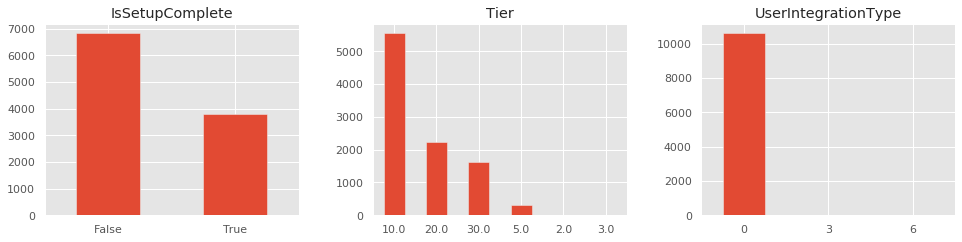

In [0]:
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, categorical_feature in enumerate(categorical_features):
  df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i], rot=0).set_title(categorical_feature)

fig.tight_layout(pad=3.0)

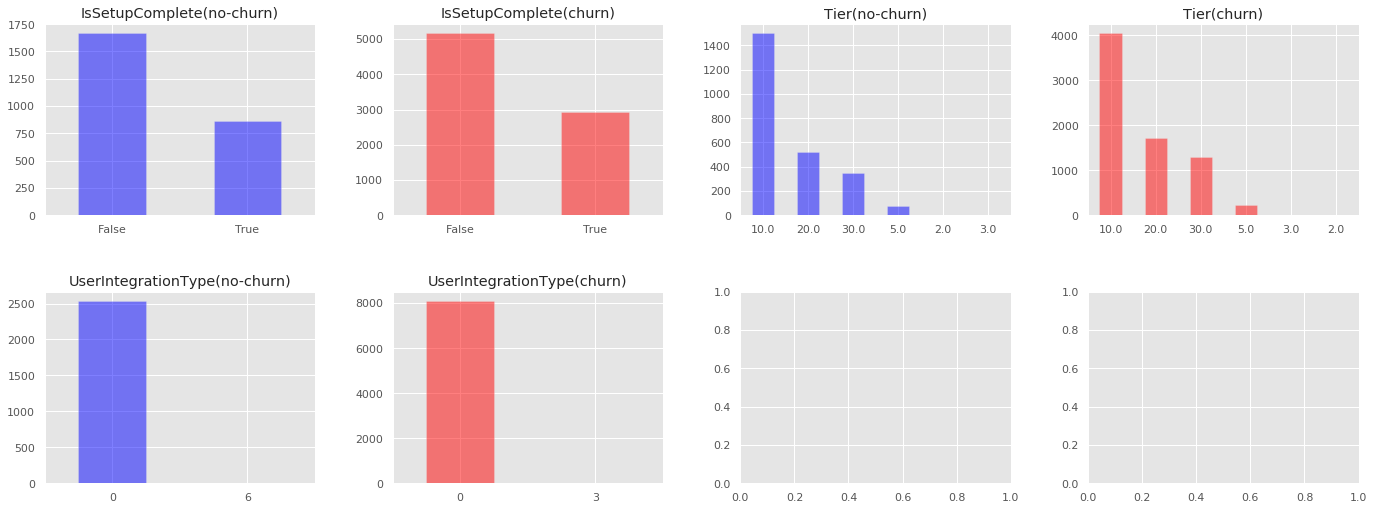

In [0]:
plt.style.use('ggplot')

# 2 row 4 col
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

df[df.Churn == False]['IsSetupComplete'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 0], rot=0).set_title('IsSetupComplete(no-churn)')
df[df.Churn == True]['IsSetupComplete'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 1], rot=0).set_title('IsSetupComplete(churn)')

df[df.Churn == False]['Tier'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 2], rot=0).set_title('Tier(no-churn)')
df[df.Churn == True]['Tier'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 3], rot=0).set_title('Tier(churn)')

df[df.Churn == False]['UserIntegrationType'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[1, 0], rot=0).set_title('UserIntegrationType(no-churn)')
df[df.Churn == True]['UserIntegrationType'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[1, 1], rot=0).set_title('UserIntegrationType(churn)')

fig.tight_layout(pad=4.0)


Numerical feature distributions

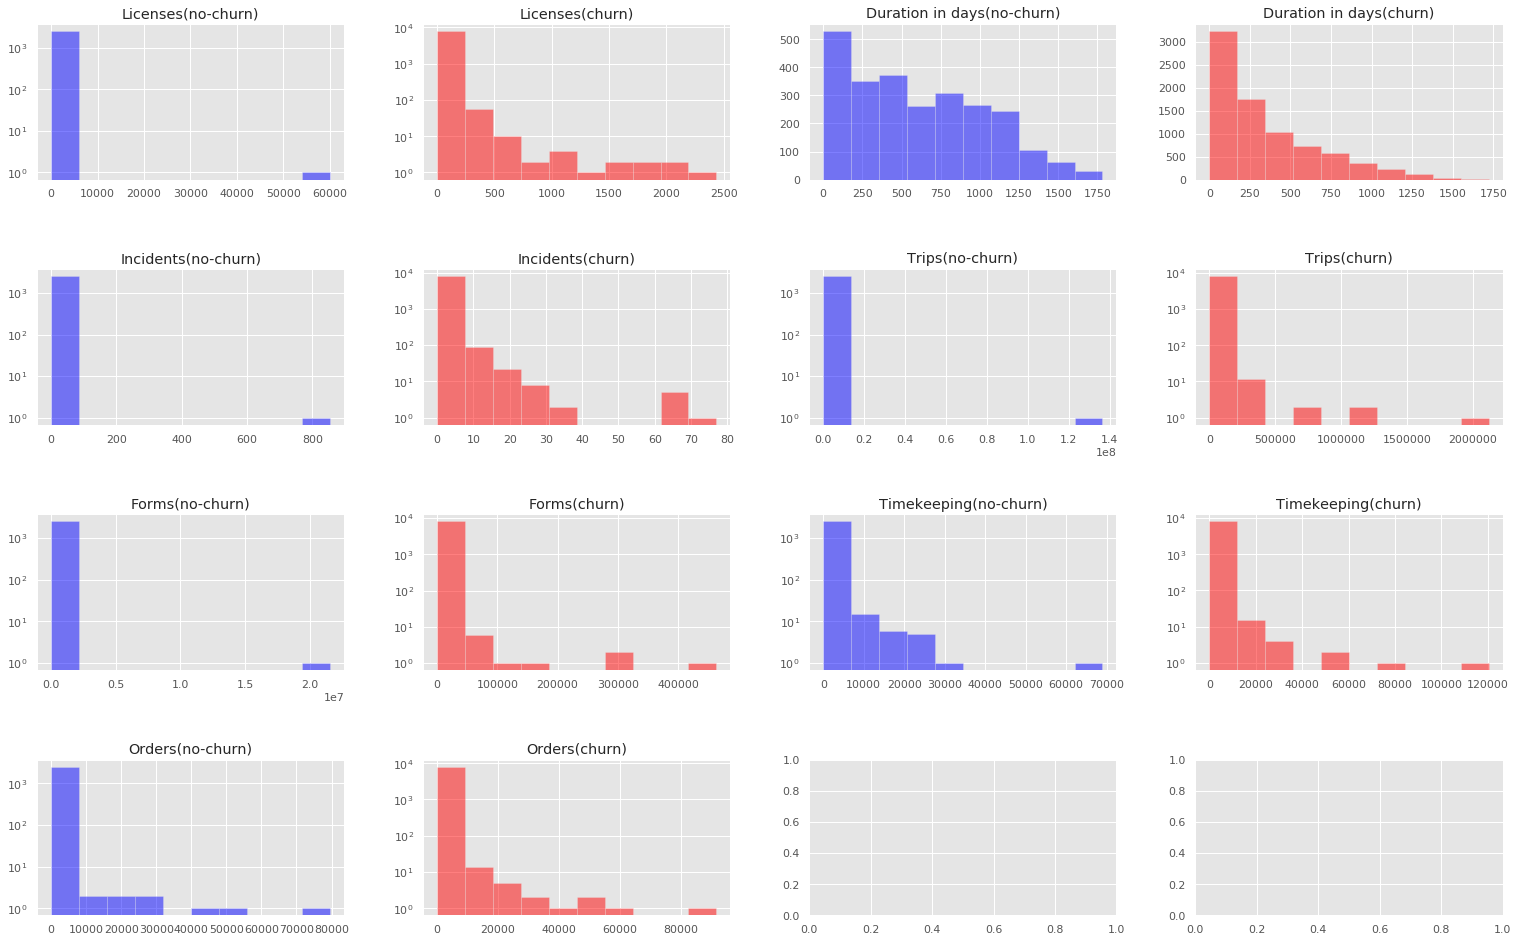

In [0]:
# numerical_features = ["Licenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

plt.style.use('ggplot')

rows, columns = 4, 4
fig, ax = plt.subplots(rows, columns, figsize=(22, 14))

df[df.Churn == False]["Licenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 0]).set_title("Licenses(no-churn)")
df[df.Churn == True]["Licenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 1]).set_title("Licenses(churn)")
ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')

df[df.Churn == False]["Duration"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 2]).set_title("Duration in days(no-churn)")
df[df.Churn == True]["Duration"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 3]).set_title("Duration in days(churn)")

df[df.Churn == False]["Incidents"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 0]).set_title("Incidents(no-churn)")
df[df.Churn == True]["Incidents"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 1]).set_title("Incidents(churn)")
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')

df[df.Churn == False]["Trips"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 2]).set_title("Trips(no-churn)")
df[df.Churn == True]["Trips"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 3]).set_title("Trips(churn)")
ax[1, 2].set_yscale('log')
ax[1, 3].set_yscale('log')

df[df.Churn == False]["Forms"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 0]).set_title("Forms(no-churn)")
df[df.Churn == True]["Forms"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 1]).set_title("Forms(churn)")
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

df[df.Churn == False]["Timekeeping"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 2]).set_title("Timekeeping(no-churn)")
df[df.Churn == True]["Timekeeping"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 3]).set_title("Timekeeping(churn)")
ax[2, 2].set_yscale('log')
ax[2, 3].set_yscale('log')

df[df.Churn == False]["Orders"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("Orders(no-churn)")
df[df.Churn == True]["Orders"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("Orders(churn)")
ax[3, 0].set_yscale('log')
ax[3, 1].set_yscale('log')

fig.tight_layout(pad=4.0)

Correlation Matrix and Heatmap

In [0]:
df = df[categorical_features + [target] + numerical_features]

df.corr()

Out[22]:

,IsSetupComplete,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
IsSetupComplete,1.000000,0.162792,-0.008160,0.017423,0.022582,0.071984,0.081766,0.016864,0.015280,0.093970,0.057491
Tier,0.162792,1.000000,-0.009514,0.052745,-0.002359,0.024351,0.013963,-0.006628,-0.005075,0.068839,0.076547
UserIntegrationType,-0.008160,-0.009514,1.000000,-0.004576,0.002491,0.014056,0.006997,-0.000271,-0.000245,-0.001834,-0.001379
Churn,0.017423,0.052745,-0.004576,1.000000,-0.020448,-0.310104,-0.024308,-0.018127,-0.017567,-0.018077,-0.010556
Licenses,0.022582,-0.002359,0.002491,-0.020448,1.000000,0.043391,0.950224,0.991628,0.990736,0.022130,0.007767
Duration,0.071984,0.024351,0.014056,-0.310104,0.043391,1.000000,0.061243,0.025560,0.024705,0.081646,0.055123
Incidents,0.081766,0.013963,0.006997,-0.024308,0.950224,0.061243,1.000000,0.951459,0.950786,0.057192,0.041998
Trips,0.016864,-0.006628,-0.000271,-0.018127,0.991628,0.025560,0.951459,1.000000,0.999357,0.008396,0.002545
Forms,0.015280,-0.005075,-0.000245,-0.017567,0.990736,0.024705,0.950786,0.999357,1.000000,0.006520,0.002231
Timekeeping,0.093970,0.068839,-0.001834,-0.018077,0.022130,0.081646,0.057192,0.008396,0.006520,1.000000,0.126145


Out[23]:

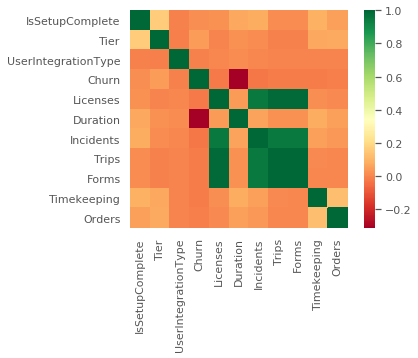

<matplotlib.axes._subplots.AxesSubplot at 0x7f858d0d8b10>

In [0]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

Create dummy variables for categorical variables

In [0]:
# cat_vars=['IsSetupComplete','Tier','UserIntegrationType']
# for var in cat_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df[var], prefix=var)
#     df1=df.join(cat_list)
#     df=df1
    
# df_vars=df.columns.values.tolist()
# to_keep=[i for i in df_vars if i not in cat_vars]
# df_final=df[to_keep]
# df_final.columns.values

In [0]:
df_final = df
df_final.head()

Out[25]:

,IsSetupComplete,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
0,True,10.0,0,0,9,1643,0,2819,0,66,0
1,True,30.0,0,1,43,227,0,0,5,4,624
2,True,10.0,0,1,17,577,10,18790,1,0,0
3,True,10.0,0,1,8,211,0,922,0,0,0
4,True,10.0,0,1,34,657,0,16683,2,0,6


In [0]:
mlflow.log_param("dataset shape", df_final.shape)

**Training**

In [0]:
# --- training with SMOTE ---
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks

X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

# SMOTENC is the only one that handles categorical values.
oversample = SMOTENC(k_neighbors=1, random_state=0, sampling_strategy=0.3, categorical_features=[0,1,2])
# oversample = SMOTENC(random_state=0, categorical_features=[0,1,2])

# under-sample
undersample = TomekLinks()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
columns = X_train.columns

if over_sample:
  data_X, data_y = oversample.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=data_X,columns=columns )
  y_train = pd.DataFrame(data=data_y,columns=['Churn'])
  
if under_sample:
  data_X, data_y = undersample.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=data_X,columns=columns )
  y_train = pd.DataFrame(data=data_y,columns=['Churn'])

# we can Check the numbers of our data
print("length of data is ",len(X_train))
print("Number of no churn in  data",len(y_train[y_train['Churn']==0]))
print("Number of churn",len(y_train[y_train['Churn']==1]))
print("Proportion of no churn data in data is ",len(y_train[y_train['Churn']==0])/len(X_train))
print("Proportion of churn data in data is ",len(y_train[y_train['Churn']==1])/len(X_train))


length of data is 7976
Number of no churn in data 1868
Number of churn 6108
Proportion of no churn data in data is 0.2342026078234704
Proportion of churn data in data is 0.7657973921765295

In [0]:
X.head()

Out[28]:

,IsSetupComplete,Tier,UserIntegrationType,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
0,True,10.0,0,9,1643,0,2819,0,66,0
1,True,30.0,0,43,227,0,0,5,4,624
2,True,10.0,0,17,577,10,18790,1,0,0
3,True,10.0,0,8,211,0,922,0,0,0
4,True,10.0,0,34,657,0,16683,2,0,6


In [0]:
# training the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

clf = XGBClassifier(random_state=42) # tree_method=hist or gpu_hist for faster computation

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
mlflow.log_param("RepeatedStratifiedKFold", cv)

# ****** RandomizedSearchCV *************
param_grid = {
    # complexity
    "max_depth": randint(6, 10), # default 6
    "min_child_weight": uniform(0.5, 2),
    "gamma": uniform(0, 1),
    "n_estimators": randint(100, 150), # default 100
    # noise
    "learning_rate": uniform(0.03, 0.2), # default 0.1    
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.7, 0.3),
    # imbalance
    "scale_pos_weight": uniform(0.3, 1)
}

tree_cv = RandomizedSearchCV(clf, param_distributions=param_grid, random_state=42, n_iter=300, cv=cv, return_train_score=True)
mlflow.log_param("RandomizedSearchCV", 'scoring=default, n_iter=300')

# ****** GridSearchCV *************
# param_grid = {
#     # complexity
#     "max_depth": [7],
#     "min_child_weight": [1],
#     "gamma": [0.9803315837160457],
#     "n_estimators": [100],
#     # noise
#     "learning_rate": [0.07666666666666666],    
#     "subsample": [0.6763644124601385],
#     "colsample_bytree": [0.8716877407512514],
#     # imbalance
#     "scale_pos_weight": [1.2]
# }

# tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='roc_auc')
# mlflow.log_param("GridSearchCV", tree_cv)

tree_cv.fit(X_train, np.ravel(y_train))

pred = tree_cv.predict(X_test)

print("Tuned XGBoost: {}".format(tree_cv.best_params_))
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

# Log mlflow attributes for mlflow UI
mlflow.log_param("hyperparameters", tree_cv.best_params_)
mlflow.sklearn.log_model(tree_cv, "model")
mlflow.log_metric("accuracy", tree_cv.score(X_test, y_test))

Tuned XGBoost: {'colsample_bytree': 0.7304414628598096, 'gamma': 0.6635017691080558, 'learning_rate': 0.031012316769243736, 'max_depth': 9, 'min_child_weight': 1.110727720688787, 'n_estimators': 101, 'scale_pos_weight': 0.9918951976926933, 'subsample': 0.8607845038010402}
Accuracy of XGBoost classifier on test set: 0.78

**Testing **

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score

# print(classification_report(y_test, pred, labels=np.unique(pred), zero_division=0))
print(classification_report(y_test, pred))

precision recall f1-score support

 0 0.69 0.26 0.38 669
 1 0.79 0.96 0.87 1990

 accuracy 0.78 2659
 macro avg 0.74 0.61 0.62 2659
weighted avg 0.77 0.78 0.75 2659

In [0]:
report = classification_report(y_test, pred, output_dict=True)
# an easy workaround to log dictionary (nested) since log_metric doesn't support it.
mlflow.log_params(report)

**Model Interpretation**

In [0]:
model = tree_cv.best_estimator_
class_names = [str(el) for el in model.classes_]
feature_names = categorical_features + numerical_features

print(model)
print("Feature names: {}".format(feature_names))
print("Class names: {}".format(class_names))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=0.7304414628598096,
 gamma=0.6635017691080558, gpu_id=-1, importance_type='gain',
 interaction_constraints='', learning_rate=0.031012316769243736,
 max_delta_step=0, max_depth=9, min_child_weight=1.110727720688787,
 missing=nan, monotone_constraints='()', n_estimators=101,
 n_jobs=0, num_parallel_tree=1, random_state=42, reg_alpha=0,
 reg_lambda=1, scale_pos_weight=0.9918951976926933,
 subsample=0.8607845038010402, tree_method='exact',
 validate_parameters=1, verbosity=None)
Feature names: ['IsSetupComplete', 'Tier', 'UserIntegrationType', 'Licenses', 'Duration', 'Incidents', 'Trips', 'Forms', 'Timekeeping', 'Orders']
Class names: ['0', '1']

The following feature importances are not exactly same as SHAP. Be careful in their interpretation.    
The detailed reference can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=importance_type). A good review can be found [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7).  

**"gain" types are most important: total gain & average gain across all trees.**

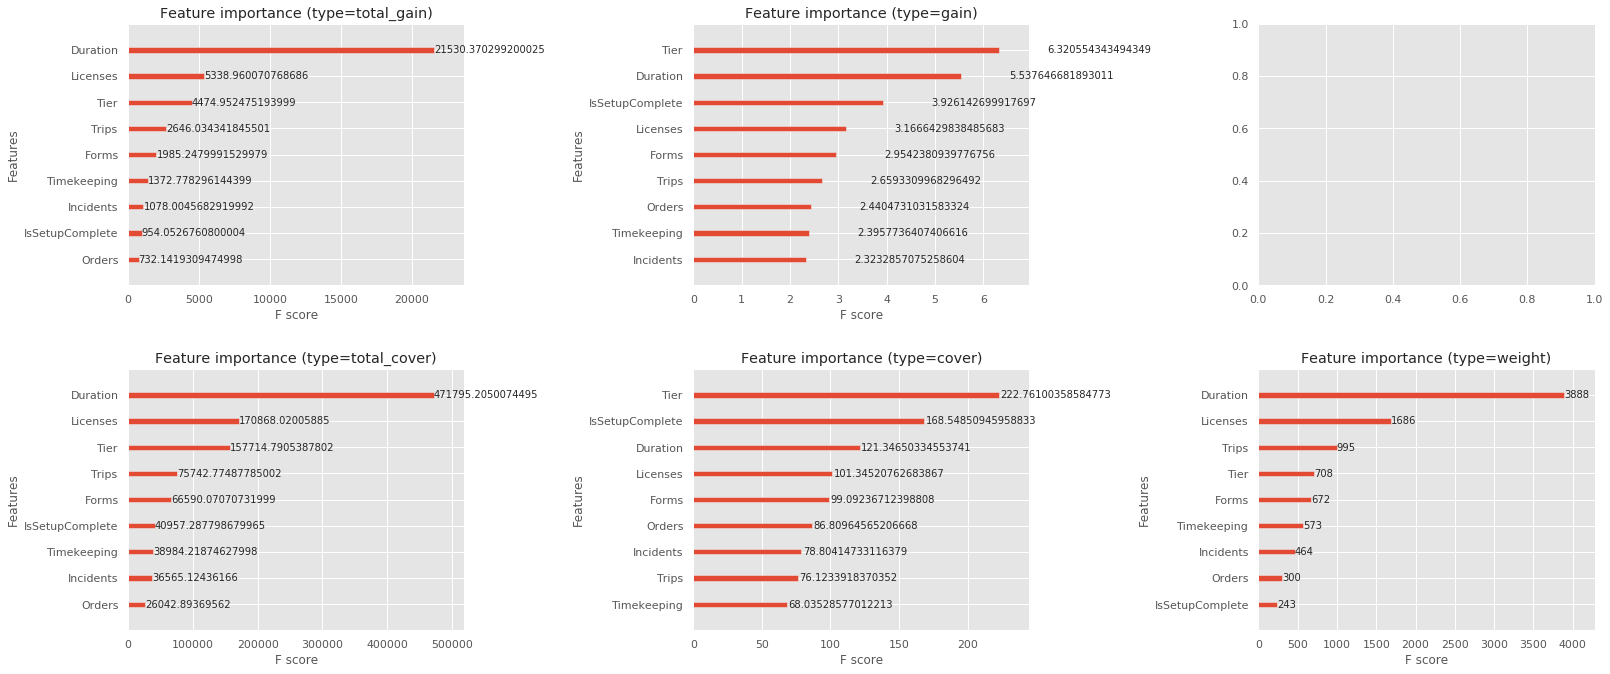

In [0]:
from xgboost import plot_importance

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 3, figsize=(23, 10))

plot_importance(model, importance_type="total_gain", ax=ax[0,0])
ax[0,0].set_title('Feature importance (type=total_gain)')

plot_importance(model, importance_type="gain", ax=ax[0,1])
ax[0,1].set_title('Feature importance (type=gain)')

plot_importance(model, importance_type="total_cover", ax=ax[1,0])
ax[1,0].set_title('Feature importance (type=total_cover)')

plot_importance(model, importance_type="cover", ax=ax[1,1])
ax[1,1].set_title('Feature importance (type=cover)')

plot_importance(model, importance_type="weight", ax=ax[1,2])
ax[1,2].set_title('Feature importance (type=weight)')

fig.tight_layout(pad=3.0)

ROC Curve for test data

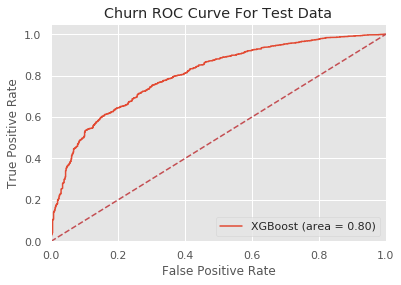

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

tree_roc_auc = roc_auc_score(y_test, tree_cv.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree_cv.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Churn ROC Curve For Test Data')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()


ROC Curve for train data

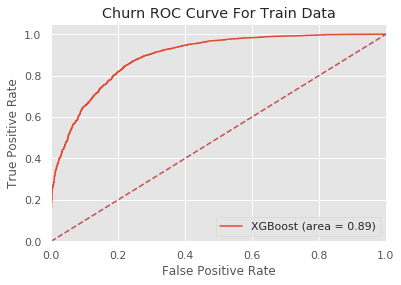

In [0]:
tree_roc_auc = roc_auc_score(y_train, tree_cv.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, tree_cv.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Churn ROC Curve For Train Data')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [0]:
mlflow.end_run()